In [ ]:
!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.1 MB/s eta 0:00:00


In [ ]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
from igraph import *

In [ ]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """

    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):

        # Simulate propagation process
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:

                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))

            # Add newly activated nodes to the set of activated nodes
            A += new_active

        spread.append(len(A))

    return(np.mean(spread))

In [ ]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()

    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)

        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [ ]:
def celf(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    # --------------------
    # Find the first node with greedy algorithm
    # --------------------

    # Calculate the first iteration sorted list
    start_time = time.time()
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]

    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------

    for _ in range(k-1):

        check, node_lookup = False, 0

        while not check:

            # Count the number of times the spread is computed
            node_lookup += 1

            # Recalculate spread of top node
            current = Q[0][0]

            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [ ]:
!pip install cairocffi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 2.0 MB/s eta 0:00:00


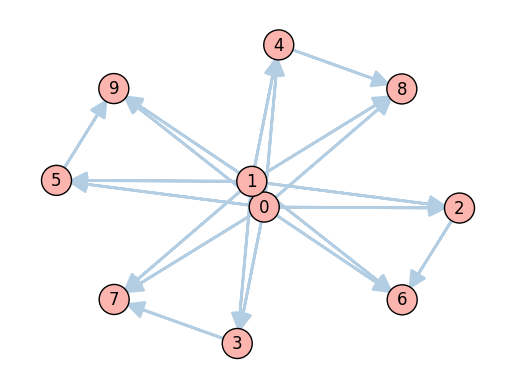

In [ ]:
import matplotlib.pyplot as plt
import igraph

# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

g = Graph(directed=True)
g.add_vertices(range(10))
g.add_edges(zip(source,target))

# Plot graph
g.vs["label"], g.es["color"], g.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
# plot(g,bbox = (200,200),margin = 20,layout = g.layout("kk"))


fig, ax = plt.subplots()
igraph.plot(g,bbox = (200,200),margin = 20,layout = g.layout("kk"), target = ax)

In [ ]:
# Run algorithms
celf_output   = celf(g,2,p = 0.2,mc = 1000)
greedy_output = greedy(g,2,p = 0.2,mc = 1000)

# Print results
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [0, 1]
greedy output: [0, 1]


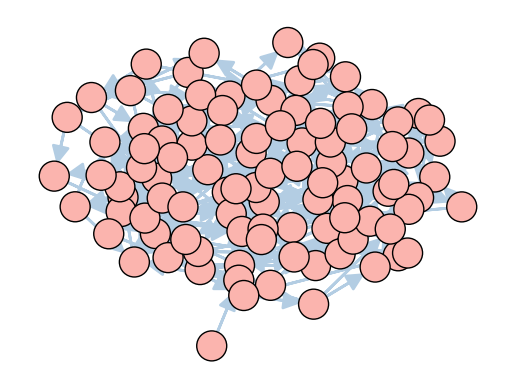

In [ ]:
import matplotlib.pyplot as plt
import igraph

# Generate Graph
G = Graph.Erdos_Renyi(n=100,m=300,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
# plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))
fig, ax = plt.subplots()
igraph.plot(G,bbox = (300, 300),margin = 11,layout = G.layout("kk"), target = ax)

In [ ]:
# Run algorithms
celf_output   = celf(G,10,p = 0.1,mc = 1000)
greedy_output = greedy(G,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

celf output:   [40, 15, 47, 63, 57, 94, 55, 26, 65, 18]
greedy output: [40, 15, 47, 63, 57, 94, 55, 26, 65, 18]


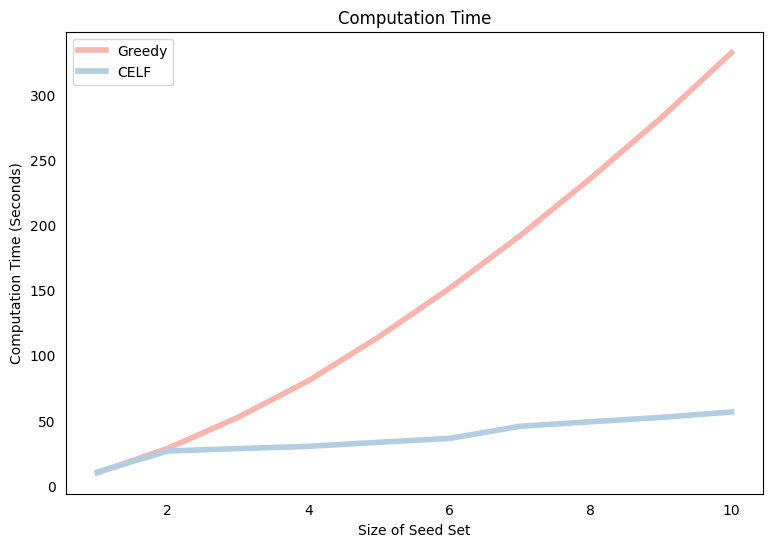

In [ ]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output[2])+1),greedy_output[2],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

In [ ]:
print(celf_output[3])

[100, 87, 7, 4, 9, 8, 21, 8, 7, 6]


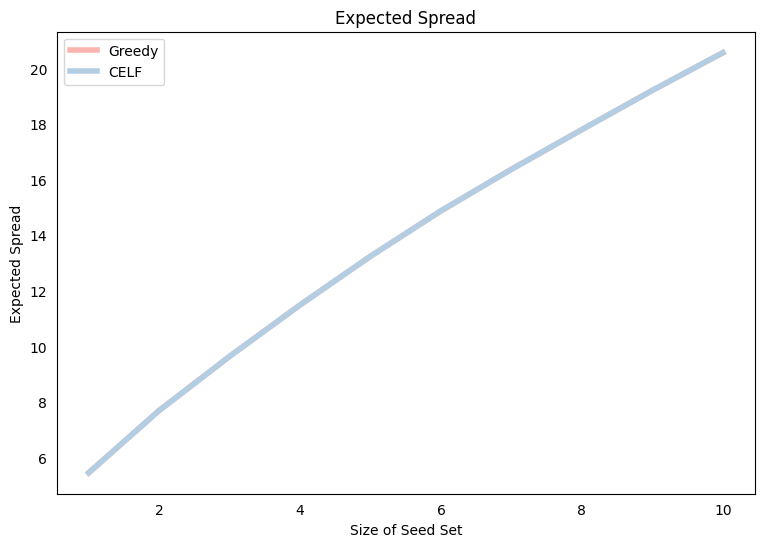

In [ ]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output[1])+1),greedy_output[1],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);

1000 499341


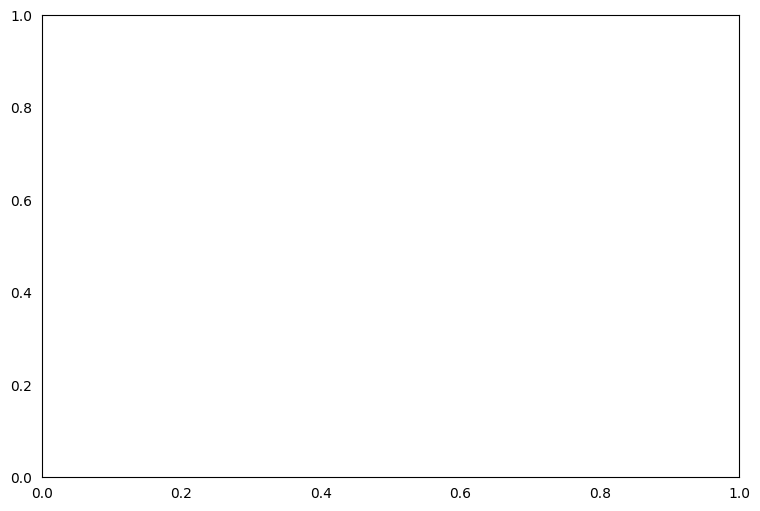

In [ ]:
import matplotlib.pyplot as plt
import igraph

# Generate Graph
G = Graph.Erdos_Renyi(n=1000,p=0.5,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
# plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))
fig, ax = plt.subplots()
# igraph.plot(G,bbox = (300, 300),margin = 11,layout = G.layout("kk"), target = ax)
print(G.vcount(), G.ecount())

In [ ]:
# Run algorithms

# Record the start time
start_time = time.time()

celf_output   = celf(G,10,p = 0.1,mc = 1000)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")